In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics


import os
import numpy as np
# ds = pd.read_csv('Dataset.csv')
# ds

## Reading dataset

In [2]:
test_gesture = './DATASET/TEST_DATASET'
train_gesture = './DATASET/TRAIN_DATASET'
valid_gesture = './DATASET/VALIDATION_DATASET'

In [3]:
def add_samples(ds,X_list,y_list):
    window_size = 30
    overlap = window_size//2

    X = ds.values
    tmp_labels = ds.iloc[:,127].values
    for i in range(ds.shape[0]//overlap-1):
        start_idx = i*overlap
        end_idx = start_idx + window_size
        X_list.append(X[start_idx:end_idx,:126])
        # print(start_idx,end_idx)
        if sum(np.where(tmp_labels[start_idx:end_idx] > 0, 0, 1)) >= 9: 
            y_list.append(np.max(X[start_idx:end_idx,127]).astype(np.int32))
        else:
            y_list.append(0)

In [45]:
def add_samples_max_overlap(ds,X_list,y_list):
    window_size = 30
    overlap = window_size//2
    
    X = ds.values
    tmp_labels = ds.iloc[:,127].values
    labels_in_window = []
    for i in range(ds.shape[0]//overlap-1):
        start_idx = i*overlap
        end_idx = start_idx + window_size
        
        labels_in_window.append(sum(tmp_labels[start_idx:end_idx] > 0.5))
        X_list.append(X[start_idx:end_idx,:126])

            
    largest_overlap_idx = 0
    largest_overlap = labels_in_window[0]
    start_idx = 0
    label = np.max(X[:,127]).astype(np.int32)
    # print(label,labels_in_window)
    y = find_local_maxima(labels_in_window,min_value=7,local_max_value=label)
    for l in y:
        y_list.append(l)
        
    

In [46]:
def find_local_maxima(array:list, min_value = 9, local_max_value=0):
    """
    returns: list with same size as input array, with 1 where the local maxima (higher than min_value) is and 0 elsewhere.
    """
    loc_max = [0 for x in array]
    for i in range(1,len(array)-1):
        if array[i] >= array[i-1] and array[i] >= array[i+1] and array[i] >= min_value: 
            loc_max[i] = local_max_value
            if array[i-1] > min_value:
                loc_max[i-1] = local_max_value
            if array[i+1] > min_value:
                loc_max[i+1] = local_max_value
        else:
            if loc_max[i] != local_max_value:
                loc_max[i] = 0
    return loc_max

In [49]:
X_train_list,y_train_list = [], []
X_test_list,y_test_list = [], []
X_valid_list, y_valid_list = [], []
full_ds = None
train_ds = None
test_ds = None
i = 0
def fill_lists(path_to_data,X_list,y_list,aug=False,train=False):
    global full_ds, i
    for file in os.listdir(path_to_data):
        add_samples_max_overlap(pd.read_csv(path_to_data+'/'+file),X_list,y_list)
        # add_samples(pd.read_csv(path_to_data+'/'+file),X_list,y_list)
        if full_ds is None:
            full_ds = pd.read_csv(path_to_data+'/'+file)
            full_ds['126'] = i
                
                
        else:
            new_ds = pd.read_csv(path_to_data+'/'+file)
            new_ds['126'] = i
            full_ds = pd.concat([full_ds,new_ds],ignore_index=True)
            if aug:
                new_ds
        i += 1

fill_lists(train_gesture,X_train_list,y_train_list)
fill_lists(test_gesture,X_test_list,y_test_list)
fill_lists(valid_gesture,X_valid_list,y_valid_list)


In [51]:
def take_not_zero(ds:pd.DataFrame):
    r = []
    for idx in ds['126'].unique():
        # print(X.loc[:,'126'])
        X = ds[ds['126']==idx]['127'].values
        min_seq = X.shape[0] 
        max_seq = 0
        current_seq = 0 
        label =  X.max()
        X = X /( X.max() if X.max() >= 1 else 1)
        mean_seq = np.mean(X)
        for value in X:
            if value != 0:
                current_seq += 1
            elif value == 0:
                if min_seq > current_seq and current_seq != 0:
                    min_seq = current_seq
                if max_seq < current_seq:
                    max_seq = current_seq
                current_seq = 0
        r.append([idx,label,min_seq,max_seq])
    return r
d = take_not_zero(full_ds)

In [52]:
k = pd.DataFrame(d,columns=['video_id','label','min_seq','max_seq'])

k.groupby('label')['min_seq','max_seq'].mean()

/tmp/ipykernel_386095/391785488.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  k.groupby('label')['min_seq','max_seq'].mean()


,min_seq,max_seq
label,,
1.0,15.611111,41.000000
2.0,23.866667,44.400000
3.0,16.047619,32.857143
4.0,16.555556,42.555556
5.0,7.133333,30.800000
6.0,12.666667,36.888889
7.0,3.666667,24.916667
8.0,6.000000,24.444444


In [53]:
k.groupby('label')['min_seq','max_seq'].mean().mean(axis=1)

/tmp/ipykernel_386095/755902479.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  k.groupby('label')['min_seq','max_seq'].mean().mean(axis=1)


label
1.0    28.305556
2.0    34.133333
3.0    24.452381
4.0    29.555556
5.0    18.966667
6.0    24.777778
7.0    14.291667
8.0    15.222222
dtype: float64

In [54]:
y = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0}
for x in y_train_list:
    y[x] += 1
print(y)

{0: 863, 1: 313, 2: 393, 3: 427, 4: 318, 5: 339, 6: 256, 7: 189, 8: 232}


In [56]:
samples = 3500
samples

3500

# Torch Dataset

In [57]:
labels_train = F.one_hot(torch.tensor(y_train_list,dtype=torch.int64),num_classes=9)
labels_test = F.one_hot(torch.tensor(y_test_list,dtype=torch.int64),num_classes=9)
labels_valid = F.one_hot(torch.tensor(y_valid_list,dtype=torch.int64),num_classes=9)

In [58]:
X_train = torch.tensor(X_train_list)
X_test = torch.tensor(X_test_list)
X_valid = torch.tensor(X_valid_list)

In [59]:
ds_train = torch.utils.data.TensorDataset(X_train,labels_train)
dataloader_train = torch.utils.data.DataLoader(ds_train,batch_size=16,drop_last = True)

ds_valid = torch.utils.data.TensorDataset(X_valid,labels_valid)
dataloader_valid = torch.utils.data.DataLoader(ds_valid,batch_size=16,drop_last = True)

ds_test = torch.utils.data.TensorDataset(X_test,labels_test)
dataloader_test = torch.utils.data.DataLoader(ds_test,batch_size=16,drop_last = True)



In [60]:
w = 1./(pd.DataFrame(ds_train[:][1].argmax(dim=1).numpy()).value_counts().sort_index().values)
w

array([0.00115875, 0.00319489, 0.00254453, 0.00234192, 0.00314465,
       0.00294985, 0.00390625, 0.00529101, 0.00431034])

In [75]:
weights = []
for x in labels_train.argmax(dim=1):
    if x.numpy() == 0:
        weights.append(2*w[x.numpy()])
    else:
        weights.append(w[x.numpy()])

[0.00234192037470726,
 0.00234192037470726,
 0.00234192037470726,
 0.002317497103128621,
 0.00234192037470726,
 0.00234192037470726,
 0.00234192037470726,
 0.00234192037470726,
 0.00234192037470726,
 0.00234192037470726]

In [76]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(torch.from_numpy(np.array(weights)),samples)
train_dataloader = torch.utils.data.DataLoader(ds_train,sampler=sampler,batch_size=16,drop_last=True)


In [77]:
dataloader_train = train_dataloader

In [78]:
lab = []
for data,labels in dataloader_train:
    lab.append(labels.argmax(dim=1).numpy())
pd.DataFrame(np.hstack(lab)).value_counts()    


0    664
5    376
2    365
7    358
8    355
4    354
3    351
1    344
6    321
dtype: int64

In [79]:
samples

3500

## Model

In [80]:
input_size = 126
num_layers = 2
hidden_size = 96
num_classes = 9
learning_rate = 3e-5

In [81]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,num_classes,bid_lstm=False):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        h0 = torch.zeros(self.num_layers,16,self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers,16,self.hidden_size).to(device)
        self.h0 = nn.Parameter(h0,requires_grad=True)
        self.c0 = nn.Parameter(c0,requires_grad=True)
        
        
        
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=0.2) 
        self.fc = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(hidden_size, num_classes) 
    
    def forward(self,x):

        
        # _, (hn, _) = self.lstm(x,(self.h0,self.c0))
        # _,hn = self.rnn(x,self.h0)
        _, (hn, _) = self.lstm(x,(self.h0,self.c0))
        # print(out.shape,hn.shape)
        hn = hn[-1]
        
        # print(hn.shape)
        out = F.dropout(hn,p=0.1,training=self.training)
        out = self.fc2(out)
        return F.log_softmax(out)
    
    def print_h0(self):
        print(self.h0,self.c0)

    

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloader_train.dataset

In [83]:
net = RNN(input_size,hidden_size,num_layers,num_classes,False) 
net.to(device)
optimizer = optim.Adam(net.parameters(),lr=learning_rate,weight_decay=2e-2)

In [84]:
acc = torchmetrics.Accuracy().to(device)
f1 = torchmetrics.F1Score(num_classes=9,average='macro').to(device)
confmat = torchmetrics.ConfusionMatrix(num_classes=9).to(device)


In [85]:
def train(epoch):
    global train_loss, train_acc, train_f1
    net.train()
    correct = 0
    epoch_loss = 0
    ConfusionMatrix = torch.zeros(size=(9,9)).to(device)
    f1_score = 0
    for batch_idx, (X_train, y_train) in enumerate(dataloader_train):
        X_train, y_train = X_train.float().to(device), y_train.to(device)
        optimizer.zero_grad()
        output = net(X_train)
        loss = F.nll_loss(output,y_train.argmax(dim=1))#,weight=weights)
        
        loss.backward()
        optimizer.step()
        label = y_train[0].data.argmax()
        epoch_loss += loss.item()
        pred = torch.exp(output)
        
        ConfusionMatrix += confmat(pred.argmax(dim=1).to(device),y_train.argmax(dim=1).to(device))
        correct += acc(pred.to(device),y_train.argmax(dim=1))#torch.sum(output.argmax(dim=1).eq(y_train.argmax(dim=1)))/output.shape[0]
        f1_score += f1(pred.argmax(dim=1).to(device),y_train.argmax(dim=1))
    train_loss.append(epoch_loss/len(dataloader_train))
    train_acc.append(correct/len(dataloader_train))
    train_f1.append(f1_score/len(dataloader_train))
    if epoch % 50 == 0 :
        print(f'TRAIN Epoch {epoch} Loss: {epoch_loss/len(dataloader_train)} Accuracy: {correct/len(dataloader_train)} F1 : {f1_score/len(dataloader_train)}')
        print(f'TRAIN Epoch {epoch} CONF MAT {ConfusionMatrix}')


In [86]:
def test(epoch,dataloader):
    global test_loss, test_acc, test_f1
    with torch.no_grad():
        net.train(False)
        epoch_loss = 0 
        accuracy = 0
        ConfusionMatrix = torch.zeros(size=(9,9)).to(device)
        f1_score = 0
        for batch_idx, (X_train, y_train) in enumerate(dataloader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            output = net(X_train.float())
            pred = output[-1].squeeze(0).argmax()
            label = y_train[0].data.argmax()
            loss = F.nll_loss(output,y_train.argmax(dim=1))#,weight=weights)
            epoch_loss += loss.item()
            pred = torch.exp(output)
            ConfusionMatrix += confmat(pred.argmax(dim=1).to(device),y_train.argmax(dim=1).to(device))
        
            accuracy += acc(pred.to(device),y_train.argmax(dim=1).to(device))#torch.sum(output.argmax(dim=1).eq(y_train.argmax(dim=1)))/output.shape[0]
            f1_score += f1(pred.argmax(dim=1).to(device),y_train.argmax(dim=1).to(device))
        test_loss.append(epoch_loss/len(dataloader))
        test_acc.append(accuracy/len(dataloader))
        test_f1.append(f1_score/len(dataloader))
        if epoch % 50 == 0 :
            print(f'TEST Epoch {epoch} Loss: {epoch_loss/len(dataloader)}, Accuracy: {accuracy/len(dataloader)} F1 : {f1_score/len(dataloader)} \n')
            print(f'TEST Epoch {epoch} CONF MAT {ConfusionMatrix}\n')

In [87]:
train_loss = []
test_loss = []

train_acc = []
test_acc = []

train_f1 = []
test_f1 = []

for i in range(1000):  
    train(i)
    test(i,dataloader_valid)

/tmp/ipykernel_386095/3103631480.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


TRAIN Epoch 0 Loss: 2.193599562032507 Accuracy: 0.1249999925494194 F1 : 0.044226307421922684
TRAIN Epoch 0 CONF MAT tensor([[177., 467.,   0.,   0.,   9.,   0.,  36.,   0.,   0.],
        [ 64., 244.,   0.,   0.,  16.,   0.,  15.,   0.,   0.],
        [ 96., 241.,   0.,   0.,  11.,   0.,  12.,   0.,   0.],
        [112., 246.,   0.,   0.,  13.,   0.,   9.,   0.,   0.],
        [101., 221.,   0.,   0.,  11.,   0.,  11.,   0.,   0.],
        [ 52., 267.,   0.,   0.,   5.,   0.,  19.,   0.,   0.],
        [ 84., 233.,   0.,   0.,  13.,   0.,   4.,   0.,   0.],
        [ 82., 270.,   0.,   0.,   7.,   0.,  14.,   0.,   0.],
        [ 59., 224.,   0.,   0.,  14.,   0.,  29.,   0.,   0.]],
       device='cuda:0')
TEST Epoch 0 Loss: 2.1904134111745015, Accuracy: 0.1026785746216774 F1 : 0.07336995005607605 

TEST Epoch 0 CONF MAT tensor([[ 88.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 98.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [117.,   0.,   0.,   0.,   0.,

In [ ]:
test(50,dataloader_test)

In [ ]:
torch.save(net.state_dict(), './L2H96_W30Overlap15/net9classes_alldata')

In [ ]:
def smoothe(x:list,alpha=0.9):
    smoothed_x = [x[0]]
    for i in range(1,len(x)):
        smoothed_x.append(alpha*smoothed_x[i-1] + x[i-1]*(1-alpha))
    return smoothed_x

train_acc, test_acc = [x.cpu().numpy() for x in train_acc], [x.cpu().numpy() for x in test_acc] 
train_f1, test_f1 = [x.cpu().numpy() for x in train_f1], [x.cpu().numpy() for x in test_f1] 

In [ ]:
smoothing_param = 0.9

train_loss_sm = smoothe(train_loss,alpha=smoothing_param)
test_loss_sm = smoothe(test_loss,alpha=smoothing_param)

train_acc_sm = smoothe(train_acc,alpha=smoothing_param)
test_acc_sm = smoothe(test_acc,alpha=smoothing_param)

train_f1_sm = smoothe(train_f1,alpha=smoothing_param)
test_f1_sm = smoothe(test_f1,alpha=smoothing_param)

Text(0.5, 1.0, 'F1')

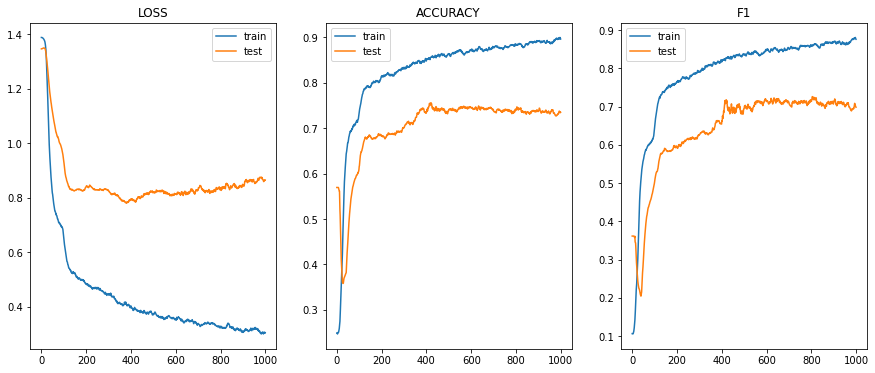

In [35]:
import matplotlib.pyplot as plt
epochs = 1000

fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,6))
ax1.plot(range(epochs),train_loss_sm,label='train')
ax1.plot(range(epochs),test_loss_sm,label='test')
ax1.legend()
ax1.set_title('LOSS')


ax2.plot(range(epochs),train_acc_sm,label='train')
ax2.plot(range(epochs),test_acc_sm,label='test')
ax2.legend()
ax2.set_title('ACCURACY')

ax3.plot(range(epochs),train_f1_sm,label='train')
ax3.plot(range(epochs),test_f1_sm,label='test')
ax3.legend()
ax3.set_title('F1')
# window 30, overlap 15, 13 -> action 

In [57]:
model = RNN(input_size,hidden_size,num_layers,num_classes) 

In [58]:
model

RNN(
  (lstm): LSTM(126, 64, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(126, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [60]:
model.(torch.load('./L2H64_W30Overlap15/model'))

<All keys matched successfully>

In [61]:
model

RNN(
  (lstm): LSTM(126, 64, num_layers=2, batch_first=True, dropout=0.5)
  (rnn): RNN(126, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
import matplotlib.pyplot as plt
epochs = 1000

fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,6))
ax1.plot(range(epochs),train_loss_sm,label='train')
ax1.plot(range(epochs),test_loss_sm,label='test')
ax1.legend()
ax1.set_title('LOSS')


ax2.plot(range(epochs),train_acc_sm,label='train')
ax2.plot(range(epochs),test_acc_sm,label='test')
ax2.legend()
ax2.set_title('ACCURACY')

ax3.plot(range(epochs),train_f1_sm,label='train')
ax3.plot(range(epochs),test_f1_sm,label='test')
ax3.legend()
ax3.set_title('F1')
# window 30, overlap 15, 13 -> action 

Text(0.5, 1.0, 'F1')

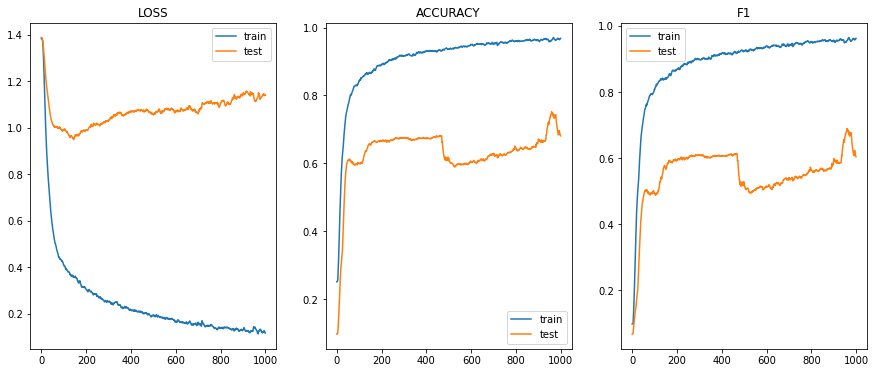

In [232]:
import matplotlib.pyplot as plt
epochs = 1000

fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,6))
ax1.plot(range(epochs),train_loss_sm,label='train')
ax1.plot(range(epochs),test_loss_sm,label='test')
ax1.legend()
ax1.set_title('LOSS')


ax2.plot(range(epochs),train_acc_sm,label='train')
ax2.plot(range(epochs),test_acc_sm,label='test')
ax2.legend()
ax2.set_title('ACCURACY')

ax3.plot(range(epochs),train_f1_sm,label='train')
ax3.plot(range(epochs),test_f1_sm,label='test')
ax3.legend()
ax3.set_title('F1')
# window 30, overlap 15, 13 -> action 

Text(0.5, 1.0, 'F1')

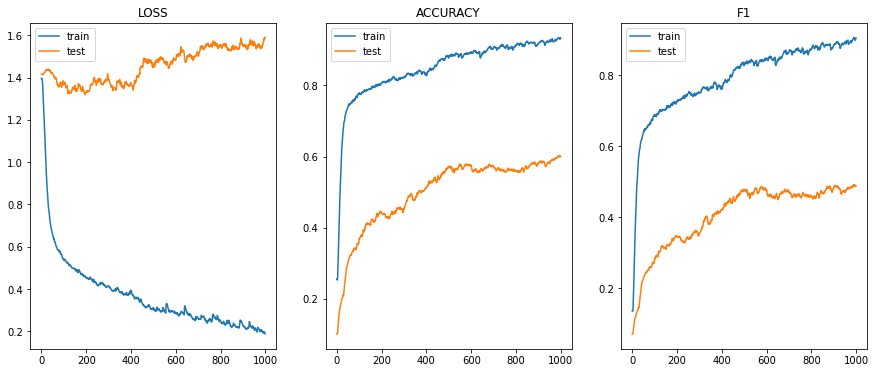

In [95]:
import matplotlib.pyplot as plt
epochs = 1000

fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,6))
ax1.plot(range(epochs),train_loss_sm,label='train')
ax1.plot(range(epochs),test_loss_sm,label='test')
ax1.legend()
ax1.set_title('LOSS')


ax2.plot(range(epochs),train_acc_sm,label='train')
ax2.plot(range(epochs),test_acc_sm,label='test')
ax2.legend()
ax2.set_title('ACCURACY')

ax3.plot(range(epochs),train_f1_sm,label='train')
ax3.plot(range(epochs),test_f1_sm,label='test')
ax3.legend()
ax3.set_title('F1')
# window 30, overlap 15, 13 -> action 

Text(0.5, 1.0, 'F1')

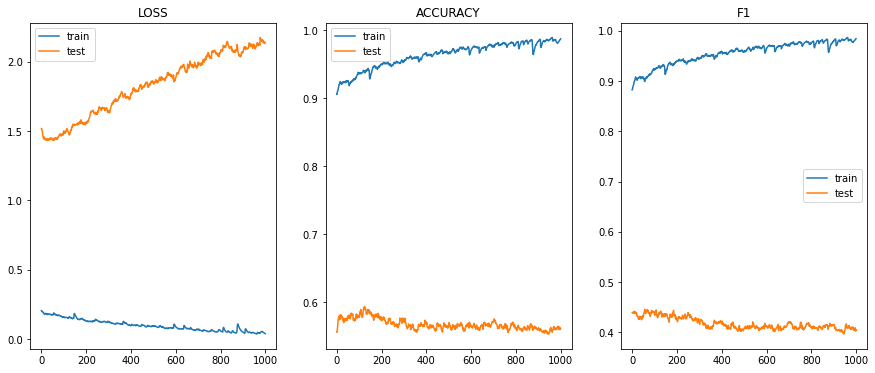

In [197]:
import matplotlib.pyplot as plt
epochs = 1000

fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,6))
ax1.plot(range(epochs),train_loss_sm,label='train')
ax1.plot(range(epochs),test_loss_sm,label='test')
ax1.legend()
ax1.set_title('LOSS')


ax2.plot(range(epochs),train_acc_sm,label='train')
ax2.plot(range(epochs),test_acc_sm,label='test')
ax2.legend()
ax2.set_title('ACCURACY')

ax3.plot(range(epochs),train_f1_sm,label='train')
ax3.plot(range(epochs),test_f1_sm,label='test')
ax3.legend()
ax3.set_title('F1')
#STANDARTIZED, weight_decay 7e-2, 16
# window 60, overlap 30, 30 -> action 

In [649]:
net.print_h0()

Parameter containing:
tensor([[[ 2.6974e-02,  7.5904e-03,  6.8030e-03,  2.1992e-02,  2.1326e-02,
          -1.0677e-02,  3.4281e-03,  1.4928e-02],
         [ 1.5160e-02,  1.4075e-02,  8.5506e-03,  2.2673e-02,  2.1326e-02,
          -1.4848e-02,  2.3215e-03,  1.5103e-02],
         [ 2.2373e-02, -2.4106e-03, -1.6134e-03,  1.2250e-02,  1.1697e-02,
          -9.8259e-04,  1.5308e-02,  4.9923e-03],
         [ 2.0835e-02,  6.5704e-03,  5.2382e-03,  2.2711e-02,  1.7933e-02,
          -1.1810e-02,  6.7041e-03,  1.0574e-02]],

        [[ 4.1223e-04,  8.3483e-04, -8.5932e-04,  1.9870e-03,  2.4907e-03,
           9.6854e-07, -9.4269e-05,  1.0730e-03],
         [-3.1950e-03,  5.7733e-03, -5.9949e-03,  7.6081e-03,  7.9693e-03,
          -4.0424e-03,  4.0913e-03, -1.4617e-04],
         [ 3.8240e-04, -1.7261e-03,  1.7774e-03, -2.0479e-03, -2.1116e-03,
           1.0303e-03, -1.3975e-03, -2.8787e-03],
         [ 5.1274e-03, -5.3943e-03,  5.3291e-03, -4.8094e-03, -4.4134e-03,
           5.4965e-03, -5.

In [887]:
pd.DataFrame(ds_train[:][1].argmax(dim=1).numpy()).value_counts()

0    332
3     88
2     59
1     52
dtype: int64

In [944]:
pd.DataFrame(ds_train[:][1].argmax(dim=1).numpy()).value_counts()

0    969
2    182
3    139
1    112
dtype: int64

In [743]:
ds_train[:][1].argmax(dim=1).numpy()

array([0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2,
       0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 3, 0, 0, 3, 3, 0, 3, 0, 3, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 3, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 0, 3, 3,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2])

In [902]:
pd.DataFrame(ds_train[:][1].argmax(dim=1).numpy()).value_counts()

0    969
2    182
3    139
1    112
dtype: int64

In [757]:
pd.DataFrame(ds_train[:][1].argmax(dim=1).numpy()).value_counts()

0    118
2     52
1     46
3     21
dtype: int64